In [1]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    
   
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "brain1", data_nomi = "brain")

Dataset yuklab olingan. brain1/brain papkasini ni tekshiring.


In [2]:
from glob import glob 
from torch.utils.data import DataLoader , random_split , Dataset 
from PIL import Image 
from torchvision import transforms as T
import os  

class BrainDataset (Dataset):
    def __init__ (self, root , transformations = None):
        self.im_path = glob(f"{root}/*/*/*/*/*")
        
        self.transformations = transformations  
        
        
        self.klass_nomi = {} 
        klass_qiymati = 0
        
        
        for idx, yulak in enumerate(self.im_path):
            klass_nomi = self.klassni_olib_kelish(yulak)
            if klass_nomi not in self.klass_nomi: 
                self.klass_nomi[klass_nomi] = klass_qiymati
                klass_qiymati += 1

    def klassni_olib_kelish(self, yulak): 
        return os.path.dirname(yulak).split(os.sep)[-1]  
    
    def __len__ (self) : 
        return len(self.im_path)
    
    def __getitem__ (self , indeks):
        im = Image.open(self.im_path[indeks])
        if self.transformations:  
            im = self.transformations(im)  
        javob = self.klass_nomi[self.klassni_olib_kelish(self.im_path[indeks])]
        return im, javob  

tfs = T.Compose([T.Resize((224,224)), T.ToTensor() , T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


ds = BrainDataset(root="brain1", transformations=tfs)
tr_ds = BrainDataset(root="brain1", transformations=tfs)

print(len(ds))
print(ds.klass_nomi)
klass_nomi = ds.klass_nomi

klasss = klass_nomi.keys()
klasslar = list(klasss)
print(klasslar)


C:\Users\Muhammadziyo\anaconda3\envs\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


259
{'aneurysm': 0, 'cancer': 1, 'tumor': 2}
['aneurysm', 'cancer', 'tumor']


In [3]:
sample_rasm, sample_javob = ds[0]
print("Type of rasm:", type(sample_rasm))
print("Type of javob:", type(sample_javob))

Type of rasm: <class 'torch.Tensor'>
Type of javob: <class 'int'>


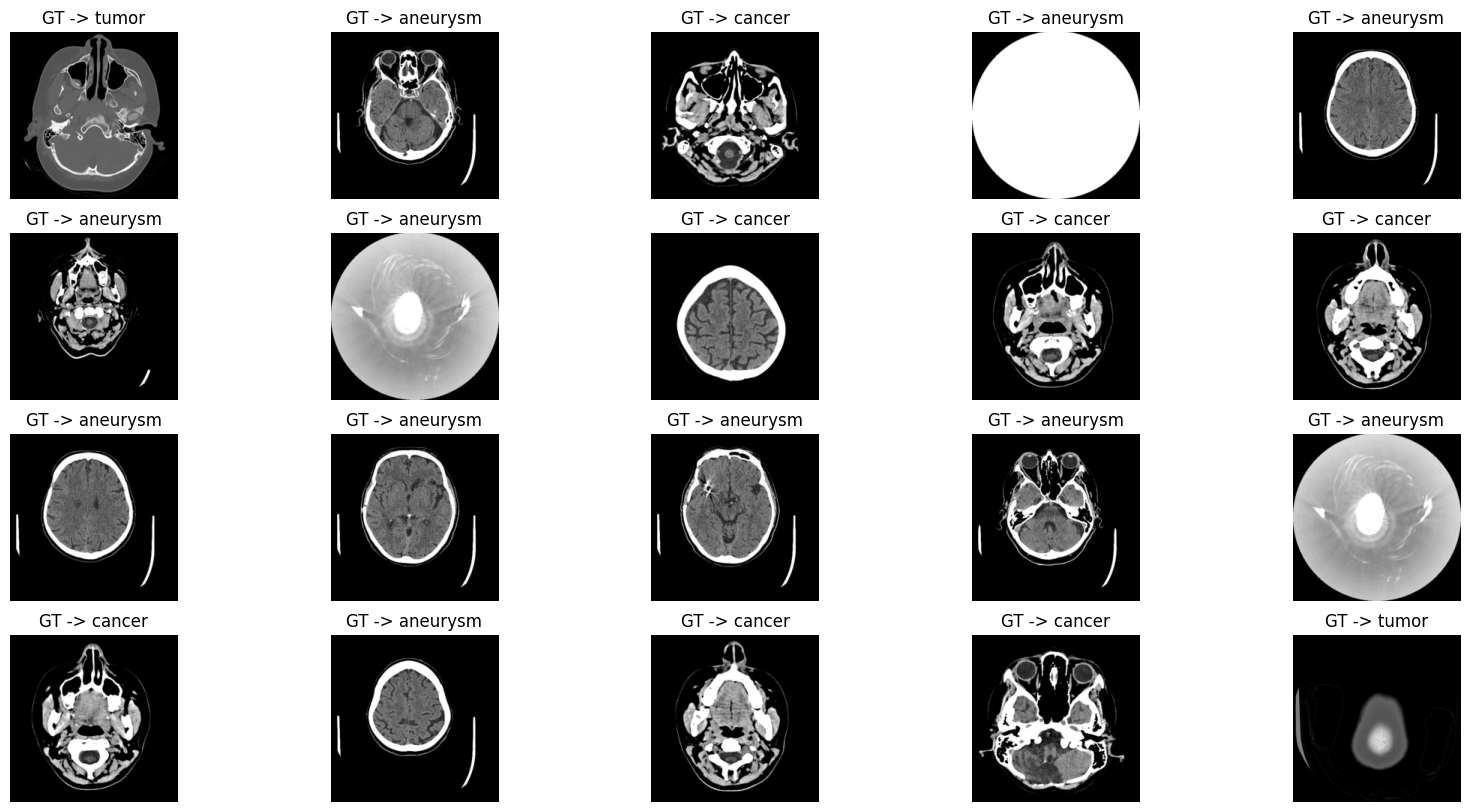

In [4]:
from utils import visualize
visualize(data = ds, rasmlar_soni = 20, qatorlar = 4, cmap = 'gray', klass_nomlari = klasslar)


In [5]:
split = [0.8 , 0.1 , 0.1]

all_len = len(ds)
tr_len = int(all_len * split[0])
val_len = int(all_len * split[1])
ts_len= all_len - tr_len - val_len

print(len(ds))
print (tr_len)
print (val_len)
print (ts_len)

259
207
25
27


In [6]:
tr_ds, val_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, val_len, ts_len])
print(len(tr_ds))
print(len(val_ds))
print(len(ts_ds))

207
25
27


In [7]:

bs = 64

tr_dl = DataLoader(dataset=tr_ds, batch_size=bs, shuffle=True, num_workers=0)
val_dl = DataLoader(dataset=val_ds, batch_size=bs, shuffle=False, num_workers=0)
ts_dl = DataLoader(dataset=ts_ds, batch_size=bs, shuffle=False, num_workers=0)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
                

4
1
1


In [8]:
import timm 

model = timm.create_model (model_name = "efficientnet_b0", pretrained = True , num_classes = len(klass_nomi))
model                           

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [9]:
import torch
from torch import nn


class Model(nn.Module):



    def __init__(self, in_chs, out_chs,in_fs, ks,s, p, n_cls) :
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_chs, out_channels = out_chs, kernel_size=ks, stride= s, padding = p)
        self.conv_2 = nn.Conv2d(in_channels=out_chs, out_channels = out_chs*2, kernel_size=ks, stride= s, padding = p)
        self.conv_3 = nn.Conv2d(in_channels=out_chs*2, out_channels = out_chs*4, kernel_size=ks, stride= s, padding = p)

        self.linear_1 = nn.Linear(in_features=in_fs, out_features= in_fs // 2)
        self.linear_2 = nn.Linear(in_features=in_fs //2 , out_features= n_cls)
        self.act = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size =2, stride = 2)


    def forward(self, inp):

      out = self.conv_1(inp)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_2(out)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_3(out)
      out = self.act(out)
      out = self.mp(out)

      print(out.shape)

      bs= inp.shape[0]
      out = out.view(bs, -1)

      out= self.linear_1(out)
      out = self.act(out)
      out = self.linear_2(out)

      return out

rasm = torch.rand(1, 3, 224, 224)
model = Model(in_chs = 3, out_chs=8, in_fs= 25088 , ks=3 , s=1, p=1, n_cls=3)
model(rasm).shape

torch.Size([1, 32, 28, 28])


torch.Size([1, 3])

In [10]:
epochs = 10
device =   "cpu" 
model.to(device)
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [11]:
from tqdm import tqdm
import os

best_acc = 0
prefix = "brain"

for epoch in range(epochs):
    model.train()
    print(f"{epoch + 1} - epoch jarayonlari boshlandi")

    epoch_loss, epoch_acc, total = 0, 0, 0

    for i, batch in tqdm(enumerate(tr_dl)):
        im, javob = batch  # Changed 'rasm' to 'im'
        print(type(javob))
        #labels = labels.to(device)
        im, javob = im.to(device), javob.to(device)  # Changed 'rasm' to 'im'
        total += im.shape[0]  # Changed 'rasm' to 'im'

        preds = model(im)  # Changed 'rasm' to 'im'
        loss = loss_fn(preds, javob)
        pred_cls = torch.argmax(preds.data, dim=1)
        epoch_acc += (pred_cls == javob).sum().item()
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1} - epoch train jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi train loss     -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi train accuracy     -> {(epoch_acc / total):.3f}")

    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0

        for ids, batch in tqdm(enumerate(val_dl)):
            im, javob = batch  # Changed 'rasm' to 'im'
            im, javob = im.to(device), javob.to(device)  # Changed 'rasm' to 'im'
            val_total += im.shape[0]  # Changed 'rasm' to 'im'

            preds = model(im)  # Changed 'rasm' to 'im'
            loss = loss_fn(preds, javob)
            pred_cls = torch.argmax(preds.data, dim=1)

            val_epoch_acc += (pred_cls == javob).sum().item()
            val_epoch_loss += loss.item()

            val_acc = val_epoch_acc / val_total

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1} - epoch validation jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi validation loss     -> {(val_epoch_loss / len(val_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi validation accuracy     -> {(val_acc):.3f}")

    if val_acc > best_acc:
        os.makedirs("modellar", exist_ok=True)
        best_acc = val_acc
        torch.save(model.state_dict(), f"modellar/{prefix}_best_model.pth")


1 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:11, 11.76s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:21, 10.82s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:33, 10.94s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:43, 10.81s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1 - epoch train jarayoni natijalari :
 1- epochdagi train loss     -> 4.775
 1- epochdagi train accuracy     -> 0.444


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.64it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1 - epoch validation jarayoni natijalari :
 1- epochdagi validation loss     -> 3.892
 1- epochdagi validation accuracy     -> 0.640
2 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:08,  8.17s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:18,  9.46s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:29,  9.96s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:37,  9.47s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2 - epoch train jarayoni natijalari :
 2- epochdagi train loss     -> 2.526
 2- epochdagi train accuracy     -> 0.531


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.40it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2 - epoch validation jarayoni natijalari :
 2- epochdagi validation loss     -> 1.715
 2- epochdagi validation accuracy     -> 0.480
3 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:10, 10.35s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:20, 10.19s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:28,  9.43s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:38,  9.51s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3 - epoch train jarayoni natijalari :
 3- epochdagi train loss     -> 0.938
 3- epochdagi train accuracy     -> 0.671


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.78it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3 - epoch validation jarayoni natijalari :
 3- epochdagi validation loss     -> 0.621
 3- epochdagi validation accuracy     -> 0.640
4 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:08,  8.89s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:20, 10.78s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:31, 10.48s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:39,  9.82s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4 - epoch train jarayoni natijalari :
 4- epochdagi train loss     -> 0.613
 4- epochdagi train accuracy     -> 0.657


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.76it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4 - epoch validation jarayoni natijalari :
 4- epochdagi validation loss     -> 0.595
 4- epochdagi validation accuracy     -> 0.760
5 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:09,  9.29s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:19,  9.95s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:28,  9.26s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:38,  9.66s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5 - epoch train jarayoni natijalari :
 5- epochdagi train loss     -> 0.279
 5- epochdagi train accuracy     -> 0.908


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.50it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5 - epoch validation jarayoni natijalari :
 5- epochdagi validation loss     -> 0.177
 5- epochdagi validation accuracy     -> 0.880
6 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:22, 21.91s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:30, 14.27s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:39, 11.85s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:49, 12.35s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

6 - epoch train jarayoni natijalari :
 6- epochdagi train loss     -> 0.130
 6- epochdagi train accuracy     -> 0.952


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.61it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

6 - epoch validation jarayoni natijalari :
 6- epochdagi validation loss     -> 0.118
 6- epochdagi validation accuracy     -> 0.920
7 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:08,  8.21s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:19, 10.01s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:29,  9.93s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:39,  9.77s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

7 - epoch train jarayoni natijalari :
 7- epochdagi train loss     -> 0.056
 7- epochdagi train accuracy     -> 0.986


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.61it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

7 - epoch validation jarayoni natijalari :
 7- epochdagi validation loss     -> 0.029
 7- epochdagi validation accuracy     -> 1.000
8 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:09,  9.72s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:19,  9.75s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:28,  9.22s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:36,  9.18s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

8 - epoch train jarayoni natijalari :
 8- epochdagi train loss     -> 0.039
 8- epochdagi train accuracy     -> 0.990


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.53it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

8 - epoch validation jarayoni natijalari :
 8- epochdagi validation loss     -> 0.013
 8- epochdagi validation accuracy     -> 1.000
9 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:11, 11.01s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:19,  9.81s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:29,  9.65s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:38,  9.70s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

9 - epoch train jarayoni natijalari :
 9- epochdagi train loss     -> 0.026
 9- epochdagi train accuracy     -> 0.990


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.79it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

9 - epoch validation jarayoni natijalari :
 9- epochdagi validation loss     -> 0.014
 9- epochdagi validation accuracy     -> 1.000
10 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


1it [00:10, 10.03s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


2it [00:20, 10.22s/it]

<class 'torch.Tensor'>
torch.Size([64, 32, 28, 28])


3it [00:31, 10.45s/it]

<class 'torch.Tensor'>
torch.Size([15, 32, 28, 28])


4it [00:41, 10.29s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

10 - epoch train jarayoni natijalari :
 10- epochdagi train loss     -> 0.021
 10- epochdagi train accuracy     -> 0.981


0it [00:00, ?it/s]

torch.Size([25, 32, 28, 28])


1it [00:00,  1.50it/s]


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

10 - epoch validation jarayoni natijalari :
 10- epochdagi validation loss     -> 0.083
 10- epochdagi validation accuracy     -> 0.920


In [12]:
im, javob = next(iter(ts_dl))


model.eval ()
preds = []
images = []
lbls = []

for im, javob in zip(im, javob):
  rasm, javob = im.to(device), javob.to(device)
  # print(rasm.unsqueeze(0).shape)
  pred = model(im.unsqueeze(0))
  print(pred.shape)
  pred_class = torch.argmax(pred, dim =1)
  images.append(im)
  lbls.append(javob)
  preds.append(pred_class)
print(len(preds))

torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1, 32, 28, 28])
torch.Size([1, 3])
torch.Size([1

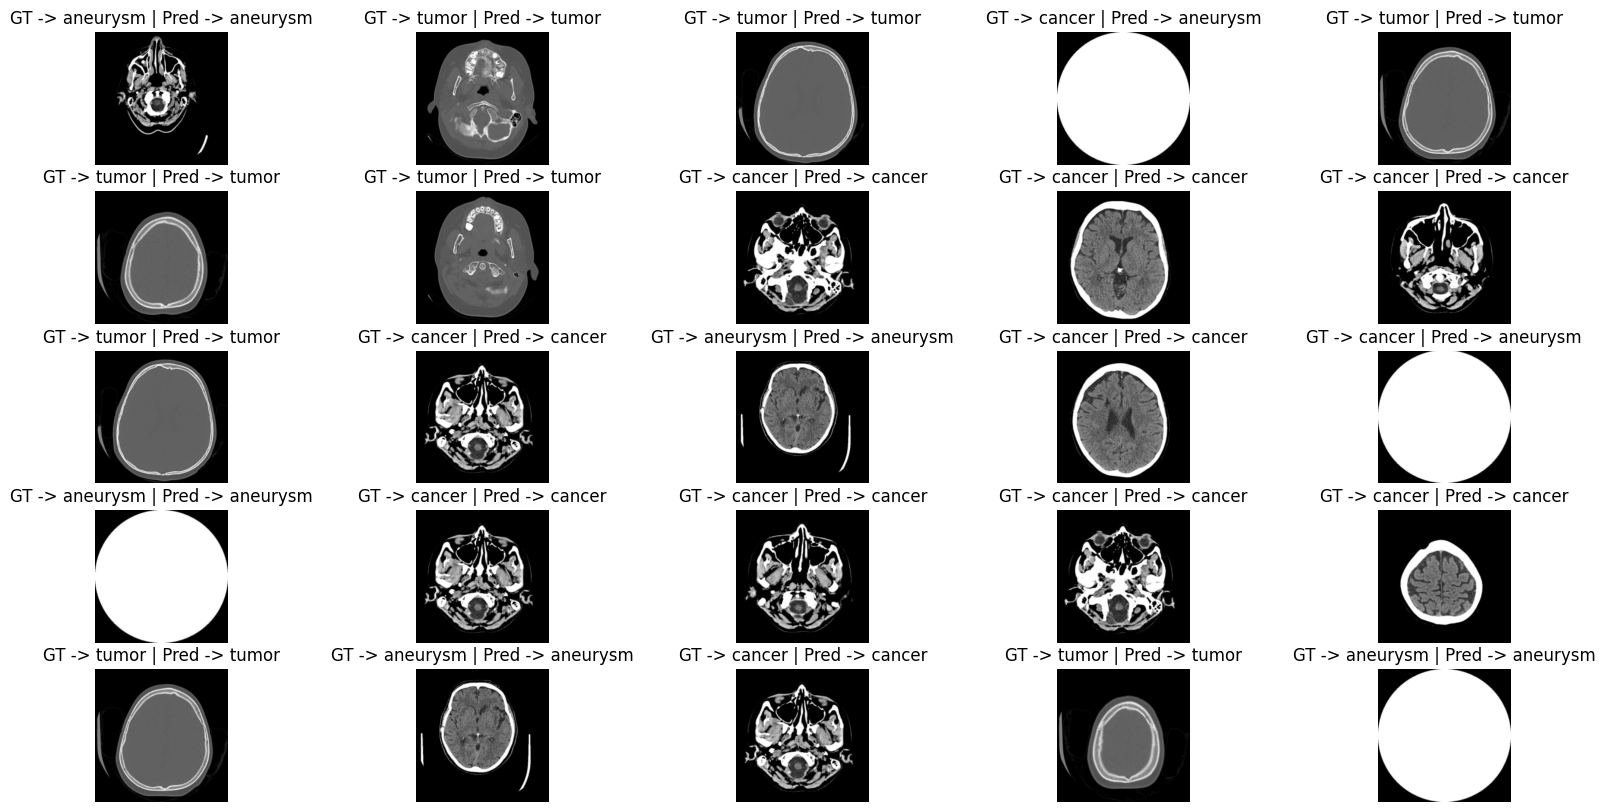

In [15]:
import random 
from utils import tensor_2_im 
from matplotlib import pyplot as plt 

num_im, row = 25, 5 

plt.figure(figsize=(20, 10))
indekslar = [random.randint(0, len(images) - 1) for _ in range(num_im)]

for i, indeks in enumerate(indekslar): 
    im = images[indeks]
    javob = klasslar[lbls[indeks]]  # Convert label to class name
    pred = klasslar[preds[indeks].item()]  # Convert prediction to class name
    
    plt.subplot(row, num_im // row, i + 1) 
    plt.imshow(tensor_2_im(im, t_type="gray"))
    plt.axis("off")
    plt.title(f"GT -> {javob} | Pred -> {pred}")

plt.show()


torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


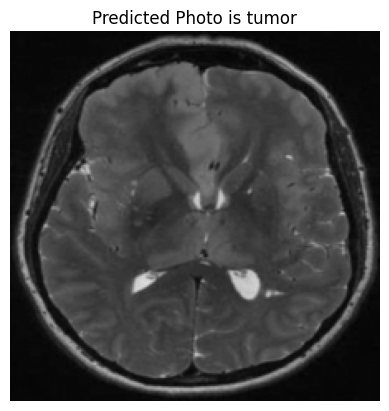

In [20]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("brain_tumor2.webp")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()


torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


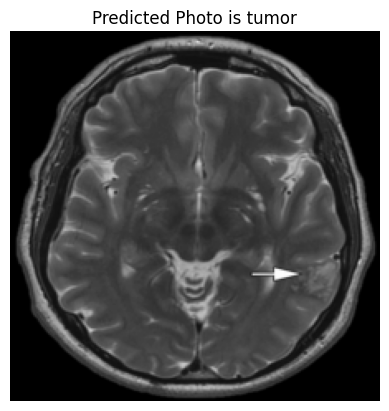

In [21]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("brain_tumor1.webp")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()


torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


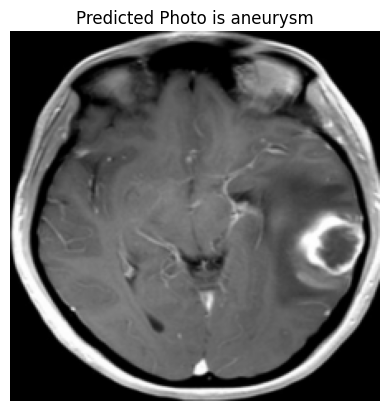

In [22]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("brain_cancer1.jpg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()


torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


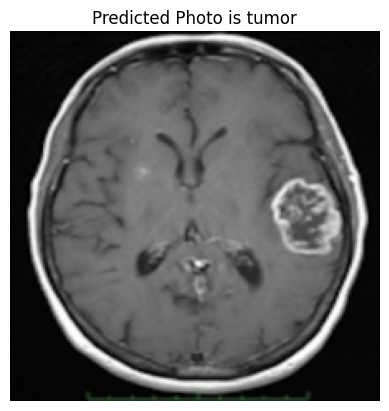

In [23]:
from PIL import Image
import torchvision.transforms as tfs
from matplotlib import pyplot as plt 
import numpy as np

rasm = Image.open("aneurysm3.webp")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim=1)
plt.imshow(tensor_2_im(tensor_im, t_type="gray"))
plt.axis('off')
plt.title(f"Predicted Photo is {list(klass_nomi.keys())[pred_class.item()]}")
plt.show()
